<a href="https://colab.research.google.com/github/sergioGarcia91/ML_and_EDA/blob/main/01c_Sismos_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN - Dataset: Sismos_V01.csv


> *Ser tan rápidos como el más lento, \
> y ser tan lentos como el más rápido.*

**Autor:** Sergio Andrés García Arias  
**Versión 01:** Diciembre 2023

# Introducción

En este Notebook utilizaremos el algoritmo de agrupamiento *Density-Based Spatial Clustering of Applications with Noise* `DBSCAN`. Este algoritmo se puede considerar como un algoritmo de clasificación no supervisada y se basa en la densidad espacial de los elementos.

> **Observación:** Aunque se ha enfatizado su fundamento en análisis espacial, es importante destacar que DBSCAN puede aplicarse también a conjuntos de datos no espaciales. Sin embargo, se requiere una comprensión clara de cómo se adapta el algoritmo a esta variedad de datos.

## ¿Cómo funciona?

El algoritmo DBSCAN opera considerando la proximidad entre los elementos y una cantidad mínima de elementos, identificando grupos o "clusters" sin requerir etiquetas previas. Los puntos núcleo son aquellos que cumplen con ambos criterios mencionados. Estos puntos desempeñan el papel de pivotes en el proceso de formación de clusters.

<figure>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg' width=300px \>

Los puntos marcados como A (color rojo) son puntos núcleo. Los puntos B y C (color amarillo) son densamente alcanzables desde A y densamente conectados con A, y pertenecen al mismo clúster. El punto N (color azul) es un punto ruidoso que no es núcleo ni densamente alcanzable. (`MinPts=3` o `MinPts=4`)

*Fuente: [Wikipedia](https://es.wikipedia.org/wiki/DBSCAN)*
</figure>





# Inicio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time

from datetime import datetime
from sklearn.cluster import DBSCAN # Para agrupar los sismos

#Cargar CSV

In [2]:
# Vamos a cargar esta vez desde una URL el archivo
url ='https://github.com/sergioGarcia91/ML_and_EDA/raw/main/Datasets/Sismos_V01.csv'
df = pd.read_csv(url, sep=';', decimal=',')
df = df.dropna()
df = df.drop_duplicates(subset=['FECHA - HORA UTC', 'LATITUD (°)', 'LONGITUD (°)'])
df = df.reset_index(drop=True)
df.head()

,FECHA - HORA UTC,TIPO MAGNITUD,LATITUD (°),LONGITUD (°),X_3116,Y_3116,PROF. (Km),MAGNITUD,FASES,RMS (Seg),GAP (°),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),DEPARTAMENTO,MUNICIPIO,ESTADO
0,15/09/2019 2:20,MLr_3,5.711,-73.881,1021767.3,1123281.898,100.05,1.6,9.0,0.3,140.0,2.404,2.404,3.8,Santander,Albania,manual
1,8/08/2020 19:17,MLr_3,5.713,-73.861,1023982.6,1123503.864,123.00,1.5,12.0,0.8,96.0,4.031,4.031,7.1,Santander,Albania,manual
2,26/02/2020 22:32,MLr_3,5.716,-73.867,1023317.9,1123835.376,108.85,1.5,18.0,0.4,96.0,1.131,1.131,2.3,Santander,Albania,manual
3,14/09/2018 4:07,MLr,5.717,-73.817,1028856.4,1123948.230,107.61,1.2,12.0,0.3,99.0,1.344,1.344,2.4,Santander,Albania,manual
4,19/03/2018 6:44,MLr,5.719,-73.864,1023650.1,1124167.257,112.70,1.5,12.0,0.4,130.0,1.768,1.768,3.5,Santander,Albania,manual


In [3]:
# Trabajaremos solo en kilometros
df['X (km)'] = df['X_3116'] / 1000
df['Y (km)'] = df['Y_3116'] / 1000
df.head()

,FECHA - HORA UTC,TIPO MAGNITUD,LATITUD (°),LONGITUD (°),X_3116,Y_3116,PROF. (Km),MAGNITUD,FASES,RMS (Seg),GAP (°),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),DEPARTAMENTO,MUNICIPIO,ESTADO,X (km),Y (km)
0,15/09/2019 2:20,MLr_3,5.711,-73.881,1021767.3,1123281.898,100.05,1.6,9.0,0.3,140.0,2.404,2.404,3.8,Santander,Albania,manual,1021.7673,1123.281898
1,8/08/2020 19:17,MLr_3,5.713,-73.861,1023982.6,1123503.864,123.00,1.5,12.0,0.8,96.0,4.031,4.031,7.1,Santander,Albania,manual,1023.9826,1123.503864
2,26/02/2020 22:32,MLr_3,5.716,-73.867,1023317.9,1123835.376,108.85,1.5,18.0,0.4,96.0,1.131,1.131,2.3,Santander,Albania,manual,1023.3179,1123.835376
3,14/09/2018 4:07,MLr,5.717,-73.817,1028856.4,1123948.230,107.61,1.2,12.0,0.3,99.0,1.344,1.344,2.4,Santander,Albania,manual,1028.8564,1123.948230
4,19/03/2018 6:44,MLr,5.719,-73.864,1023650.1,1124167.257,112.70,1.5,12.0,0.4,130.0,1.768,1.768,3.5,Santander,Albania,manual,1023.6501,1124.167257


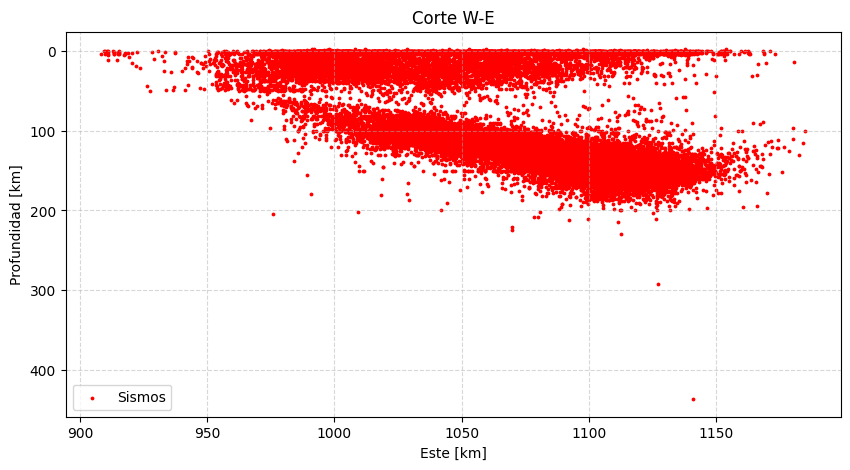

In [4]:
plt.figure(figsize=(10,5))

plt.scatter(df['X (km)'],
            df['PROF. (Km)'],
            c='r',
            s=3,
            label='Sismos')
plt.gca().invert_yaxis()

plt.grid(ls='--', alpha=0.5)
plt.legend()
plt.xlabel('Este [km]')
plt.ylabel('Profundidad [km]')
plt.title('Corte W-E')

plt.show()

# DBSCAN

Para llevar a cabo la agrupación o generación de clusters en el catálogo de eventos sísmicos, utilizaremos la clase [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) implementada en la biblioteca `Scikit-Learn`.

Para simplificar el proceso, ajustaremos únicamente los siguientes parámetros:

- `eps`: la distancia máxima entre los eventos.
- `min_samples`: el número mínimo de muestras por cluster.
- `metric`: se dejará por defecto en la distancia euclidiana.

In [5]:
X = df[['X (km)', 'Y (km)', 'PROF. (Km)']].to_numpy()
X = X[::2,:] # Para no saturar tanto la RAM
X

array([[1021.7673  , 1123.281898,  100.05    ],
       [1023.3179  , 1123.835376,  108.85    ],
       [1023.6501  , 1124.167257,  112.7     ],
       ...,
       [1095.8315  , 1337.365312,  135.4     ],
       [1094.2857  , 1337.804645,  136.7     ],
       [1093.1803  , 1338.797918,  148.      ]])

In [6]:
# eps 5 ... min 500
# eps 5 ... min 100
# eps 5 ... min 10
# eps 7 ... min 500
# eps 7 ... min 100
# eps 7 ... min 50
# eps 8 ... min 500
# eps 8 ... min 50
# eps 9 ... min 500
# eps 9 ... min 50
# eps 9 ... min 10
# eps 9 ... min 1
# eps 9 ... min 5
# eps 9 ... min 800
distancia = 9 # en kilometros
cantidadMinimaSismos = 800 # cuantos para formar un cluster, cuenta el centroide

modeloDBSCAN = DBSCAN(eps=distancia,
                      min_samples=cantidadMinimaSismos,
                      ) #Crear el modelo

tinicio = time.perf_counter() # Segundos
modeloDBSCAN.fit(X) # Ajustar
tfinal = time.perf_counter() # Segundos
tiempo = tfinal - tinicio
print('Segundos empleados: ',tiempo)

Segundos empleados:  59.77484817799996


In [7]:
clusters = modeloDBSCAN.labels_ # Etiquetas o clusters
print('Total clusters: ', len(np.unique(clusters))-1)
np.unique(clusters) # -1 refiere a Ruido

Total clusters:  1


array([-1,  0])

In [8]:
outliers_X = X[clusters == -1]
cluster_X = X[clusters != -1]
etiquetas = clusters[clusters != -1]

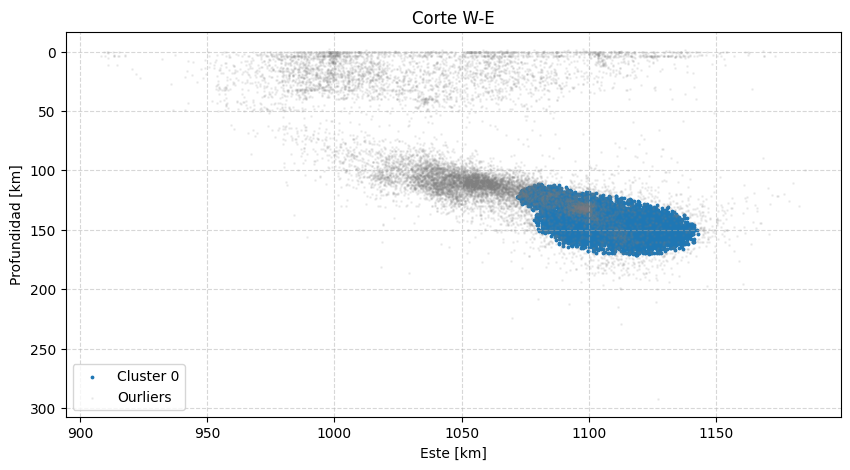

In [9]:
plt.figure(figsize=(10,5))

for cluster in np.unique(etiquetas):
  X2 = cluster_X[etiquetas == cluster]

  plt.scatter(X2[:,0],
              X2[:,2],
              s=3,
              label='Cluster {}'.format(cluster))

plt.scatter(outliers_X[:,0],
            outliers_X[:,2],
            c='grey',
            s=1,
            label='Ourliers',
            alpha=0.1)

plt.gca().invert_yaxis()

plt.grid(ls='--', alpha=0.5)
plt.legend()
plt.xlabel('Este [km]')
plt.ylabel('Profundidad [km]')
plt.title('Corte W-E')

plt.show()

In [10]:
fig = go.Figure(data=[go.Scatter3d(
     x=outliers_X[:,0],
     y=outliers_X[:,1],
     z=-1*outliers_X[:,2],
     mode='markers',
     marker=dict(
          size=1,
          color='grey',
          opacity=0.3)
     )])

for cluster in np.unique(etiquetas):
  X2 = cluster_X[etiquetas == cluster]
  fig.add_trace(go.Scatter3d(x=X2[:,0],
                             y=X2[:,1],
                             z=-1*X2[:,2],
                             mode='markers',
                             marker=dict(
                                 size=3
                                )
                             )
                )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# Observaciones

A propósito, durante el EDA, se omitió la evaluación de las columnas relacionadas con los errores de ubicación de los sismos: `ERROR LATITUD (Km)`, `ERROR LONGITUD (Km)`, `ERROR PROFUNDIDAD (Km)`. Esta información adicional podría resultar muy útil en un análisis espacial de los datos, especialmente teniendo en cuenta que el algoritmo `DBSCAN` se basa en la distancia entre los elementos.

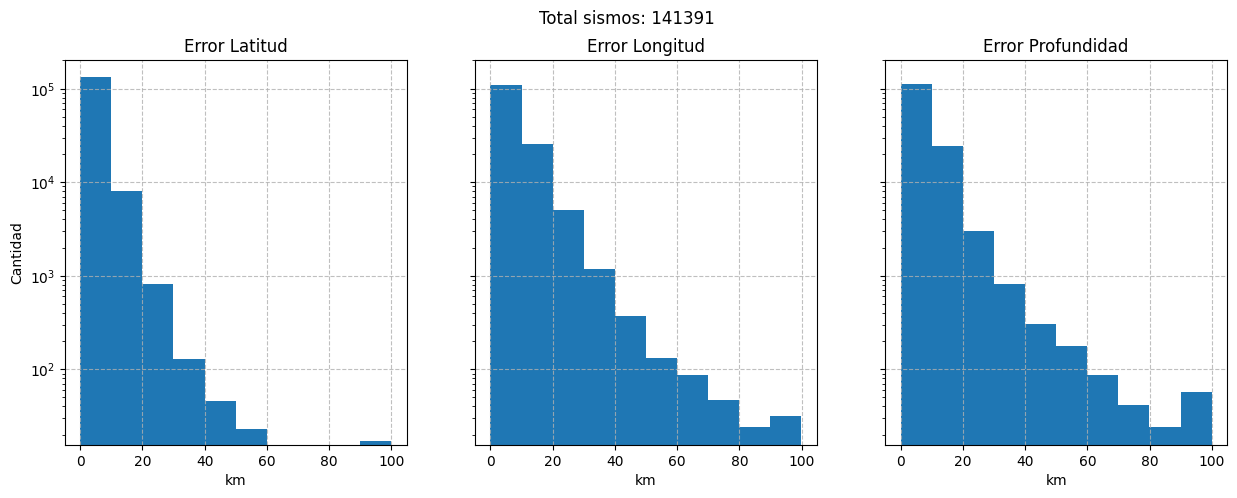

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
ax[0].hist(df['ERROR LATITUD (Km)'])
ax[0].set_title('Error Latitud')
ax[0].grid(ls='--', alpha=0.8)
ax[0].set_yscale('log') # Comentar
ax[0].set_ylabel('Cantidad')
ax[0].set_xlabel('km')

ax[1].hist(df['ERROR LONGITUD (Km)'])
ax[1].set_title('Error Longitud')
ax[1].grid(ls='--', alpha=0.8)
ax[1].set_xlabel('km')


ax[2].hist(df['ERROR PROFUNDIDAD (Km)'])
ax[2].set_title('Error Profundidad')
ax[2].grid(ls='--', alpha=0.8)
ax[2].set_xlabel('km')

plt.suptitle( 'Total sismos: {}'.format(len(df)) )
plt.show()

Tampoco se llevó a cabo un análisis profundo de las magnitudes ni del tiempo o fecha de los eventos durante el EDA.

In [12]:
df['Fecha'] = pd.to_datetime(df['FECHA - HORA UTC'],
                             dayfirst=True, # El formato inicia con el día
                             errors='coerce') # Para ignorar un error presente en el DataFrame
df.head()

,FECHA - HORA UTC,TIPO MAGNITUD,LATITUD (°),LONGITUD (°),X_3116,Y_3116,PROF. (Km),MAGNITUD,FASES,RMS (Seg),GAP (°),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),DEPARTAMENTO,MUNICIPIO,ESTADO,X (km),Y (km),Fecha
0,15/09/2019 2:20,MLr_3,5.711,-73.881,1021767.3,1123281.898,100.05,1.6,9.0,0.3,140.0,2.404,2.404,3.8,Santander,Albania,manual,1021.7673,1123.281898,2019-09-15 02:20:00
1,8/08/2020 19:17,MLr_3,5.713,-73.861,1023982.6,1123503.864,123.00,1.5,12.0,0.8,96.0,4.031,4.031,7.1,Santander,Albania,manual,1023.9826,1123.503864,2020-08-08 19:17:00
2,26/02/2020 22:32,MLr_3,5.716,-73.867,1023317.9,1123835.376,108.85,1.5,18.0,0.4,96.0,1.131,1.131,2.3,Santander,Albania,manual,1023.3179,1123.835376,2020-02-26 22:32:00
3,14/09/2018 4:07,MLr,5.717,-73.817,1028856.4,1123948.230,107.61,1.2,12.0,0.3,99.0,1.344,1.344,2.4,Santander,Albania,manual,1028.8564,1123.948230,2018-09-14 04:07:00
4,19/03/2018 6:44,MLr,5.719,-73.864,1023650.1,1124167.257,112.70,1.5,12.0,0.4,130.0,1.768,1.768,3.5,Santander,Albania,manual,1023.6501,1124.167257,2018-03-19 06:44:00


In [13]:
df.loc[101929:101933] # Localización del error

,FECHA - HORA UTC,TIPO MAGNITUD,LATITUD (°),LONGITUD (°),X_3116,Y_3116,PROF. (Km),MAGNITUD,FASES,RMS (Seg),GAP (°),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),DEPARTAMENTO,MUNICIPIO,ESTADO,X (km),Y (km),Fecha
101929,25/12/2003 4:51,Ml,6.813,-73.098,1108278.6,1245255.436,152.9,2.2,5.0,0.4,187.0,6.5,17.6,9.4,SANTANDER,LOS_SANTOS,Revisado,1108.2786,1245.255436,2003-12-25 04:51:00
101930,30/12/2003 12:46,Ml,6.813,-72.979,1121434.8,1245283.741,150.0,2.0,5.0,0.7,289.0,14.5,25.4,19.6,SANTANDER,CEPITA,Revisado,1121.4348,1245.283741,2003-12-30 12:46:00
101931,37987 03:38:04,Ml,6.813,-73.013,1117675.8,1245275.323,149.7,3.0,8.0,0.5,196.0,6.8,15.2,14.8,SANTANDER,CEPITA,Revisado,1117.6758,1245.275323,NaT
101932,2/01/2004 11:23,Ml,6.813,-72.975,1121877.0,1245284.749,151.8,2.6,5.0,0.4,225.0,6.4,22.5,12.3,SANTANDER,CEPITA,Revisado,1121.8770,1245.284749,2004-01-02 11:23:00
101933,5/01/2004 16:20,Ml,6.813,-72.996,1119555.3,1245279.499,146.0,2.3,8.0,0.4,198.0,4.7,9.9,5.8,SANTANDER,CEPITA,Revisado,1119.5553,1245.279499,2004-01-05 16:20:00


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141391 entries, 0 to 141390
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA - HORA UTC        141391 non-null  object        
 1   TIPO MAGNITUD           141391 non-null  object        
 2   LATITUD (°)             141391 non-null  float64       
 3   LONGITUD (°)            141391 non-null  float64       
 4   X_3116                  141391 non-null  float64       
 5   Y_3116                  141391 non-null  float64       
 6   PROF. (Km)              141391 non-null  float64       
 7   MAGNITUD                141391 non-null  float64       
 8   FASES                   141391 non-null  float64       
 9   RMS (Seg)               141391 non-null  float64       
 10  GAP (°)                 141391 non-null  float64       
 11  ERROR LATITUD (Km)      141391 non-null  float64       
 12  ERROR LONGITUD (Km)     141391

In [16]:
df['MAGNITUD'].quantile(0.25)

1.5

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



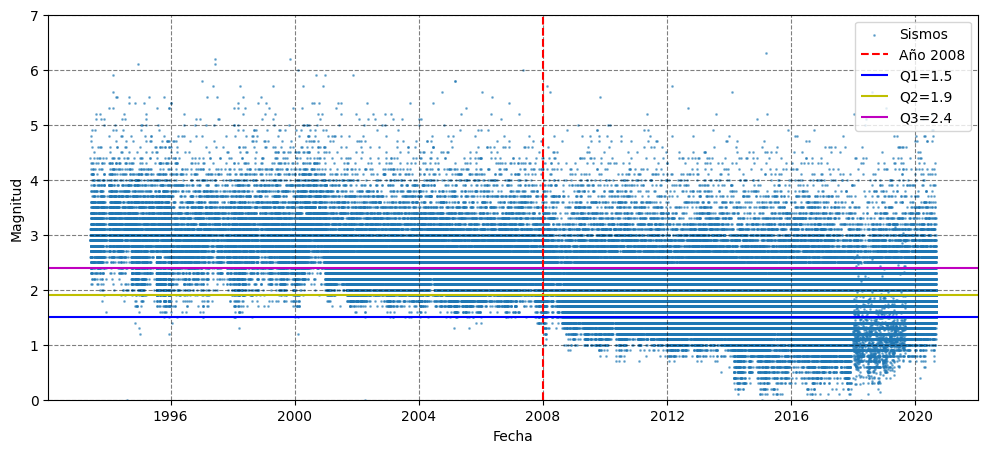

In [51]:
plt.figure(figsize=(12,5))

plt.scatter(df['Fecha'],
            df['MAGNITUD'],
            s=1,
            label='Sismos',
            alpha=0.5)

plt.vlines(x= datetime.strptime('2008', '%Y'),
           ymin=0,
           ymax=7,
           ls='--',
           color='r',
           label='Año 2008') # El limite de un aparente cambio en las magnitudes


Q1 = df['MAGNITUD'].quantile(0.25)
Q2 = df['MAGNITUD'].quantile(0.5)
Q3 = df['MAGNITUD'].quantile(0.75)

left, right = plt.xlim()

plt.hlines(y= Q1,
           xmin=left,
           xmax=right,
           ls='-',
           color='b',
           label='Q1={}'.format(Q1))

plt.hlines(y= Q2,
           xmin=left,
           xmax=right,
           ls='-',
           color='y',
           label='Q2={}'.format(Q2))

plt.hlines(y= Q3,
           xmin=left,
           xmax=right,
           ls='-',
           color='m',
           label='Q3={}'.format(Q3))


plt.grid(ls='--', color='k', alpha=0.5)
plt.xlim(left, right)
plt.ylim(0,7)
plt.xlabel('Fecha')
plt.ylabel('Magnitud')
plt.legend()

plt.show()

Ejecutar el algoritmo de DBSCAN en este conjunto de datos resultó ser un desafío, requiriendo la reducción de la información a la mitad. Además, es crucial resaltar que las dos observaciones previas sobre los errores y el parámetro del tiempo ahora don de interés.

Consideró algunos de los siguientes cuestionamientos?:

- ¿Cómo afecta el tiempo o la fecha en la clusterización?
- ¿Es necesario aplicar otro tipo de distancia?
- ¿Puede la magnitud ser un parámetro adicional para la agrupación?
- ¿Cómo se puede incorporar la magnitud y/o la fecha?
- ¿La distancia máxima o `eps` debe ser seleccionada considerando los errores?

Estos interrogantes plantean la posibilidad de ampliar el EDA y, potencialmente, llevar a una reducción adicional de la información en el conjunto de datos.

---
Cabe destacar que en este Notebook no se evaluaron criterios para determinar la idoneidad de la clasificación o clusterización realizada por DBSCAN. Esta evaluación se llevará a cabo en un próximo Notebook.

Aunque el algoritmo DBSCAN tiene muchas ventajas, también presenta algunas desventajas que es importante tener en cuenta:

1. **Sensibilidad a la Densidad:** DBSCAN puede tener dificultades para encontrar clusters de diferente densidad. Si los clusters tienen densidades significativamente distintas, puede ser complicado especificar un valor óptimo para el parámetro de densidad (`eps`).

2. **Requiere Ajuste de Parámetros:** La elección adecuada de los parámetros `eps` (radio de vecindad) y `min_samples` (número mínimo de puntos en una vecindad para formar un cluster) es crucial. En algunos casos, determinar estos valores de manera óptima puede ser no trivial y puede requerir experimentación.

3. **No Funciona Bien con Datos de Dimensionalidad Alta:** DBSCAN puede tener dificultades para manejar conjuntos de datos con dimensionalidad alta debido al problema conocido como la "maldición de la dimensionalidad". La distancia euclidiana tiende a volverse menos significativa en espacios de alta dimensión.

4. **No Puede Manejar Clusters de Forma No Convexa:** DBSCAN asume que los clusters son de forma convexa. Si los clusters tienen formas complejas y no convexas, DBSCAN puede no funcionar de manera óptima.

5. **Sensibilidad a la Escala de los Datos:** La escala de las características puede afectar el rendimiento de DBSCAN. Normalizar los datos puede ser necesario para evitar que ciertas características dominen la métrica de distancia.

6. **Problemas con Ruido:** DBSCAN puede etiquetar puntos aislados como ruido. La definición de qué se considera ruido y qué no puede depender de la elección de los parámetros y puede ser subjetiva.

7. **Dependencia de la Métrica de Distancia:** La elección de la métrica de distancia es crucial y puede afectar significativamente los resultados de DBSCAN. La distancia euclidiana es comúnmente utilizada, pero no siempre es la más apropiada para todos los conjuntos de datos.


# Fin